In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import kagglehub
# import statsmodels.api as sm

# import tensorflow_addons as tfa
import cv2
from keras import backend as K

from sklearn.preprocessing import StandardScaler
import math
from sklearn.datasets import load_iris
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Activation, Concatenate
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.datasets import mnist
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import SparseCategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GroupShuffleSplit


import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from scipy.io import wavfile
from scipy.fftpack import fft
import cv2
import os
import librosa
import librosa.display
from glob import glob
import skimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from pydub import AudioSegment
from tqdm import tqdm
import tempfile

from tensorflow.keras import regularizers
tf.debugging.set_log_device_placement(False)

import numpy as np
import os
import re

import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Metric

if os.path.isfile("myData.npz"):
    print("✅ 'data.npz' exists.")
    with np.load("myData.npz") as data:
        myData = data['myData']
        myData2 = data['myData2']
        myY = data['myY']
        myActors = data['myActors']
        myDatasets = data['myDatasets']
        myHasNoise = data['myHasNoise']
        print(np.unique(myY))
        print(np.unique(myActors))
else:

    folder = './savefiles'

    def findFilesFromPattern(pattern):
        pattern = re.compile(pattern + r'_(.*?)_(.*?)_(.*?)_(\d+)_(\d+)\.npy')
        heatmaps_dict = {}

        for filename in os.listdir(folder):
            match = pattern.match(filename)
            if match:
                dataset, actor, emotion, i, j = map(str, match.groups())
                i, j = int(i), int(j)
                filepath = os.path.join(folder, filename)
                data = np.load(filepath)

                heatmaps_dict[f'{dataset}_{actor}_{emotion}_{j // 2}_{j%2}'] = {'data': data, 'dataset': dataset, 'actor': actor, 'emotion':emotion, 'type': j, 'has_noise': (j%4 == 0 or j%4==1)}

        return heatmaps_dict

    mfccwasserstein = findFilesFromPattern('wassersteinMfccHeat')
    melwasserstein = findFilesFromPattern('wassersteinHeat')
    meltimeeuclid = findFilesFromPattern('timeMetricHeat')
    meleuclid = findFilesFromPattern('euclideanHeat')

    def load_spectrograms(prefixes, path='./savefiles'):
        patterns = []
        for prefix in prefixes:
            patterns.append(os.path.join(path, f"{prefix}_*.npy"))
        my_globs = glob(patterns[0])
        for pattern in patterns[1:]:
            my_globs = my_globs + glob(pattern)
        file_list = sorted(my_globs)
        return [np.load(file) for i, file in enumerate(file_list)]

    myRaw = load_spectrograms(["savee", 'tess', 'radvess', 'cremad'])
    print(len(mfccwasserstein))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 1]))
    print(np.array([[meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] == 0]]).shape)

    print(len(myRaw))

    myData = np.array([myRaw])
    print('finish data')
    myData = myData.astype('float32')
    myData = np.transpose(myData, (1, 2, 3, 0))
    myEmotionMap = {
        'neutral': 1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fearful':6, 'disgust':7, 'surprised':8
    }
    myY = np.array(
        [myEmotionMap[mfccwasserstein[key]['emotion']] -1 for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    print(np.unique(myY))
    myActors = np.array(
        [mfccwasserstein[key]['actor'] + '_' + mfccwasserstein[key]['dataset']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    myDatasets = np.array(
        [mfccwasserstein[key]['dataset']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    myHasNoise = np.array(
        [mfccwasserstein[key]['has_noise']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    print(np.unique(myActors))

    print(np.unique(myY))
    myY = [x -1 if x > 0 else x for x in myY]
    myY = to_categorical(myY, num_classes=6)

    myData2 = np.array([
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0],
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 1],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 0],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 1],
                        [mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0],
                        [mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 1],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 1]
                        ])
    print('finish data')
    myData2 = myData2.astype('float32')
    print(myData2.shape)
    myData2 = np.transpose(myData2, (1, 2, 3, 0))
    print(myData2.shape)

    def upload_to_gcs(bucket_name, source_file, destination_blob):
        """Upload a file to a GCS bucket."""
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(destination_blob)
        blob.upload_from_filename(source_file)
        print(f"✅ Uploaded {destination_blob} to gs://{bucket_name}/{destination_blob}")

    np.savez_compressed(
        "myData.npz",
        myData=myData,
        myData2=myData2,
        myY=myY,
        myActors=myActors,
        myDatasets=myDatasets,
        myHasNoise=myHasNoise
    )

    GCS_BUCKET = "simplicialcomplex-outputbucket"

    # upload_to_gcs(GCS_BUCKET, "myData.npz", "data/myData.npz")


45272
22636
22636
(1, 4, 32, 32)
22636
finish data
[0 2 3 4 5 6]
['01_radvess' '02_radvess' '03_radvess' '04_radvess' '05_radvess'
 '06_radvess' '07_radvess' '08_radvess' '09_radvess' '1001_cremad'
 '1002_cremad' '1003_cremad' '1004_cremad' '1005_cremad' '1006_cremad'
 '1007_cremad' '1008_cremad' '1009_cremad' '1010_cremad' '1011_cremad'
 '1012_cremad' '1013_cremad' '1014_cremad' '1015_cremad' '1016_cremad'
 '1017_cremad' '1018_cremad' '1019_cremad' '1020_cremad' '1021_cremad'
 '1022_cremad' '1023_cremad' '1024_cremad' '1025_cremad' '1026_cremad'
 '1027_cremad' '1028_cremad' '1029_cremad' '1030_cremad' '1031_cremad'
 '1032_cremad' '1033_cremad' '1034_cremad' '1035_cremad' '1036_cremad'
 '1037_cremad' '1038_cremad' '1039_cremad' '1040_cremad' '1041_cremad'
 '1042_cremad' '1043_cremad' '1044_cremad' '1045_cremad' '1046_cremad'
 '1047_cremad' '1048_cremad' '1049_cremad' '1050_cremad' '1051_cremad'
 '1052_cremad' '1053_cremad' '1054_cremad' '1055_cremad' '1056_cremad'
 '1057_cremad' '1058_

In [ ]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1)
groups = myActors#np.array([f"{d}_{a}_{c}" for d, a, c in zip(myActors, myDatasets)])

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np

def stratified_group_split_3way(y, groups, val_size=0.2, test_size=0.2, random_state=42):
    rng = np.random.default_rng(random_state)
    df = pd.DataFrame({'y': y, 'group': groups})

    group_labels = (
        df.groupby('group')['y']
          .agg(lambda s: s.value_counts().index[0])
          .reset_index()
    )

    sss_outer = StratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )

    sss_inner = StratifiedShuffleSplit(
        n_splits=1, test_size=val_size/(1 - test_size), random_state=random_state + 1
    )

    group_indices = np.arange(len(group_labels))
    for trainval_g, test_g in sss_outer.split(group_indices, group_labels['y']):
        trainval_groups = group_labels['group'].iloc[trainval_g].values
        test_groups = group_labels['group'].iloc[test_g].values

        trainval_df = group_labels.iloc[trainval_g]
        trainval_idx = np.arange(len(trainval_df))

        for train_g, val_g in sss_inner.split(trainval_idx, trainval_df['y']):
            train_groups = trainval_df['group'].iloc[train_g].values
            val_groups = trainval_df['group'].iloc[val_g].values

    # Map back to samples
    train_mask = df['group'].isin(train_groups)
    val_mask = df['group'].isin(val_groups)
    test_mask = df['group'].isin(test_groups)

    train_idx = np.where(train_mask)[0]
    val_idx = np.where(val_mask)[0]
    test_idx = np.where(test_mask)[0]

    return train_idx, val_idx, test_idx


train_idx, val_idx, test_idx = stratified_group_split_3way(y=np.argmax(myY, axis=1), groups=groups, val_size=0.1, test_size=0.2)

X_train, X_val, X_test, X_train2, X_val2, X_test2 = myData[train_idx], myData[val_idx], myData[test_idx], myData2[train_idx], myData2[val_idx], myData2[test_idx]
y_train, y_val, y_test = myY[train_idx], myY[val_idx], myY[test_idx]


# X_train, X_test, X_train2, X_test2, y_train, y_test = train_test_split(
#     myData, myData2, myY, test_size=0.2, shuffle=True, stratify=myActors, random_state=20
# )

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Model definition ---
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class CNNModel2(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(8, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class FusionNet(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.2):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(num_classes * 2, num_classes)  # combine logits/features

    def forward(self, logits1, logits2):
        # Concatenate logits from two models
        x = torch.cat([logits1, logits2], dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def entropy_from_logits(logits):
    # logits: (B, C)
    p = F.softmax(logits, dim=1)
    return -(p * (p.clamp_min(1e-8)).log()).sum(dim=1, keepdim=True)  # (B,1)

class FusionNetGated(nn.Module):
    def __init__(self):
        super().__init__()
        # small gate that looks at confidences (entropies) and max probs
        self.gate = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # outputs logit for alpha
        )

    def forward(self, logits1, logits2):
        # Build reliability features
        e1 = entropy_from_logits(logits1)              # (B,1)
        e2 = entropy_from_logits(logits2)              # (B,1)
        m1 = F.softmax(logits1, dim=1).amax(dim=1, keepdim=True)  # (B,1)
        m2 = F.softmax(logits2, dim=1).amax(dim=1, keepdim=True)  # (B,1)
        feats = torch.cat([e1, e2, m1, m2], dim=1)     # (B,4)

        alpha = torch.sigmoid(self.gate(feats))        # (B,1) in (0,1)
        fused = alpha * logits1 + (1 - alpha) * logits2
        return fused, alpha


# --- Instantiate model ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNNModel(num_classes=6).to(device)
model2 = CNNModel2(num_classes=6).to(device)

# --- Loss and optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
X_train2_tensor = torch.tensor(X_train2.transpose(0, 3, 1, 2), dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

has_noise_idx = np.where(myHasNoise[val_idx] == 0)[0]
X_val_tensor = torch.tensor(X_val[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_val2_tensor = torch.tensor(X_val2[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
y_val_tensor = torch.tensor(np.argmax(y_val[has_noise_idx], axis=1), dtype=torch.long)

has_noise_idx = np.where(myHasNoise[test_idx] == 0)[0]
X_test_tensor = torch.tensor(X_test[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_test2_tensor = torch.tensor(X_test2[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test[has_noise_idx], axis=1), dtype=torch.long)

dataset = TensorDataset(X_train_tensor, X_train2_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, X_val2_tensor, y_val_tensor)

train_loader = DataLoader(dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_tensor, X_test2_tensor, y_test_tensor), batch_size=256)

# ================================================================
# Training Setup
# ================================================================
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (if any)
else:
    device = torch.device("cpu")   # fallback
model = CNNModel().to(device)
model2 = CNNModel2().to(device)


fusion = FusionNetGated().to(device)
fusion_optimizer = torch.optim.Adam(fusion.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer= optim.Adam(model.parameters())
optimizer2= optim.Adam(model2.parameters())
num_epochs = 40

best_val_auc = 0.0
auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model.train()
    train_preds, train_labels = [], []
    for X_batch, X2_batch, y_batch in train_loader:
        X_batch, X2_batch, y_batch = X_batch.to(device), X2_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        optimizer2.zero_grad()
        fusion_optimizer.zero_grad()

        outputs = model(X_batch)
        outputs2 = model2(X2_batch)
        loss = criterion(outputs, y_batch)
        loss2 = criterion(outputs2, y_batch)
        # combined_logits = fusion(outputs, outputs2)
        # loss3 = criterion(combined_logits, y_batch)
        # loss3.backward()

        combined_logits, alpha = fusion(outputs, outputs2)
        loss = criterion(combined_logits, y_batch)

        # optional deep supervision helps
        loss = loss + 0.2*criterion(outputs, y_batch) + 0.2*criterion(outputs2, y_batch)
        loss.backward()

        train_preds.append(torch.softmax(combined_logits, dim=1))
        train_labels.append(y_batch)

        optimizer.step()

        optimizer2.step()

        fusion_optimizer.step()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, X2_val, y_val in val_loader:
            X_val, X2_val, y_val = X_val.to(device), X2_val.to(device), y_val.to(device)
            outputs = model(X_val)
            outputs2 = model2(X2_val)

            # combined_logits = fusion(outputs, outputs2)
            combined_logits, alpha = fusion(outputs, outputs2)
            preds = torch.softmax(combined_logits, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

    # Save best model
    if accuracy.item() > best_val_auc:
        best_val_auc = accuracy.item()
        torch.save(model.state_dict(), "best_model.pth")
        torch.save(model2.state_dict(), "best_model2.pth")
        torch.save(fusion.state_dict(), "best_model3.pth")
        print("✅ Saved new best model.")

    train_preds = torch.cat(train_preds)
    train_labels = torch.cat(train_labels)
    val_auc = auroc(train_preds, train_labels).item()
    val_top3 = top3acc(train_preds, train_labels).item()

    y_pred = torch.argmax(train_preds, dim=1)

    accuracy = (y_pred == train_labels).float().mean()
    print(f"Epoch {epoch+1}/{num_epochs} - train_auc: {val_auc:.4f} - train_top3_acc: {val_top3:.4f} - train_acc: {accuracy.item():.4f}")


Using device: mps


RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[256, 8, 32, 32] to have 4 channels, but got 8 channels instead

Epoch 32/40 - val_auc: 0.8514 - top3_acc: 0.8844 - val_acc: 0.5309
              precision    recall  f1-score   support

     neutral       0.49      0.80      0.61       246
       happy       0.43      0.59      0.49       297
         sad       0.52      0.50      0.51       297
       angry       0.72      0.58      0.64       297
     fearful       0.66      0.31      0.42       297
     disgust       0.54      0.46      0.50       297

    accuracy                           0.53      1731
   macro avg       0.56      0.54      0.53      1731
weighted avg       0.56      0.53      0.52      1731



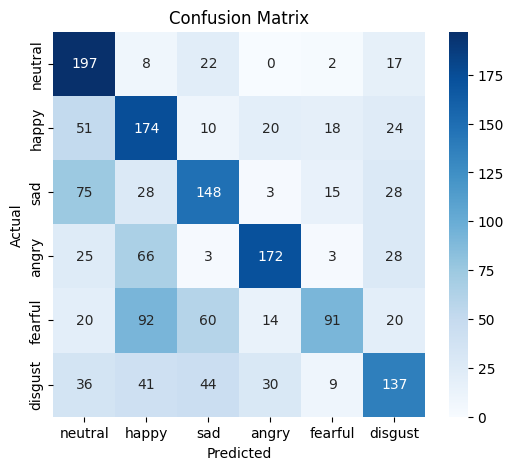

In [5]:

# ================================================================
# Evaluation
# ================================================================
model.load_state_dict(torch.load("best_model.pth"))
model2.load_state_dict(torch.load("best_model2.pth"))
fusion.load_state_dict(torch.load("best_model3.pth"))
model.eval()
model2.eval()
fusion.eval()

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, X2_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        X2_batch = X2_batch.to(device)
        outputs = model(X_batch)
        outputs2 = model2(X2_batch)

        # combined_logits = fusion(outputs, outputs2)
        combined_logits, alpha = fusion(outputs, outputs2)
        # preds = torch.softmax(combined_logits, dim=1)
        preds = torch.argmax(combined_logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(combined_logits, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

train_idx, test_idx = stratified_group_shuffle_split(y=np.argmax(myY, axis=1), groups=groups, test_size=0.2)

X_train, X_test = myData[train_idx], myData[test_idx]
y_train, y_test = myY[train_idx], myY[test_idx]

# X_train, X_test, y_train, y_test = train_test_split(
#     myData, myY, test_size=0.2, shuffle=True, stratify=myY, random_state=20
# )

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ================================================================
# Model Definition
# ================================================================
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# ================================================================
# Data Preparation
# ================================================================
# Assume X_train, y_train, X_test, y_test are numpy arrays
# Shapes: X: (N, 32, 32, 8), y: one-hot (N, 7)
print(X_train.shape)
X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
has_noise_idx = np.where(myHasNoise[test_idx] == 0)[0]
X_test_tensor = torch.tensor(X_test[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
# X_test2_tensor = torch.tensor(X_test2[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test[has_noise_idx], axis=1), dtype=torch.long)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_idx, val_idx = stratified_group_shuffle_split(y=np.argmax(y_train, axis=1), groups=groups[train_idx], test_size=0.2)

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1024)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=256)

# ================================================================
# Training Setup
# ================================================================
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (if any)
else:
    device = torch.device("cpu")   # fallback
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

best_val_auc = 0.0
auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = torch.softmax(outputs, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

    # Save best model
    if accuracy.item() > best_val_auc:
        best_val_auc = accuracy.item()
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved new best model.")

# ================================================================
# Evaluation
# ================================================================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(outputs, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")


# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()